In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import chart_studio.plotly as py
from urllib.request import urlopen
import plotly.express as px
import plotly
import json
import itertools
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
fips_to_pop = pd.read_csv("/project/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/misc_data/co-est2019-alldata.csv", encoding="latin-1")
fips_to_pop["fips"] = fips_to_pop.STATE.astype(str).str.zfill(2) + fips_to_pop.COUNTY.astype(str).str.zfill(3).replace("000", "")
fips_to_pop = fips_to_pop.set_index("fips")["CENSUS2010POP"].to_dict()

fips_to_dist = pd.read_csv("/project/biocomplexity/COVID-19_commons/2019-nCoV_spread-modeling/US_National/VA/PatchSim/data/VA_Gov_Regions.csv", dtype={"GEOID":str, "fips":str})
name_mapper = {s:s for s in fips_to_dist["VDH_Dist"].unique()}
name_mapper["Chikahominy"] = "Chickahominy"
name_mapper["Cumberland"] = "Cumberland Plateau"
name_mapper["Roanoke City"] = "Roanoke"
name_mapper["Pittsylvania Danville"] = "Pittsylvania-Danville"
for key in set(name_mapper.values()) - set(name_mapper.keys()):
    name_mapper[key] = key
fips_to_dist["VDH_Dist"] = fips_to_dist["VDH_Dist"].apply(lambda row: name_mapper[row])
fips_to_dist = dict(zip(fips_to_dist.GEOID.values, fips_to_dist.VDH_Dist.values))

dist_to_fips = {dist:[i for i,d in fips_to_dist.items() if d == dist] for dist in fips_to_dist.values()}
dist_to_pop = {dist:sum([fips_to_pop[i] for i in dist_to_fips[dist]]) for dist in dist_to_fips.keys()}

with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
    
counties["features"] = [i for i in counties["features"] if i["properties"]["STATE"] == "51"]

gisaid = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/variants/variant_samples_by_state.csv", parse_dates=["date"], dtype={"state":str})
gisaid_dates = gisaid.groupby("variant").date.min().to_dict()
va_gisaid = gisaid[gisaid.state == "51"]
va_gisaid_dates = va_gisaid.groupby("variant").date.min().to_dict()

In [3]:
state_samples = gisaid.groupby(["date", "state"]).count().rename(columns={"variant":"samples"})["samples"].reset_index().pivot(index="date", columns="state", values="samples").fillna(0)
# state_samples["51"].plot()

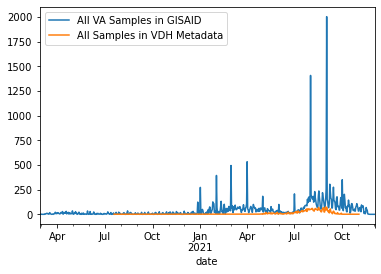

In [4]:
fig, ax = plt.subplots()
variants = pd.read_csv("/sfs/qumulo/qproject/biocomplexity/COVID-19_commons/products/external_data_collection/VDH_opioids/VDH-UVA-DSA-COVID-19-Variant.tsv", sep="\t") #, parse_dates=["report_date", "date"], dtype={"fips":str})
# print(variants.columns)
variants = variants.iloc[:, [3, 6, 8, 11, 13, 14, 15, 21]]
variants.columns = ["variant", "age", "count", "district", "fips", "outbreak", "date", "seqid"]
variants.date = pd.to_datetime(variants.date)
variants.fips = variants.fips.astype(str)
variants = variants.sort_values("date")
variants = variants.dropna(subset=["date"])
state_samples["51"].plot(label="All VA Samples in GISAID")
variants.groupby("date").count().rename(columns={"variant":"samples"})["samples"].plot(ax=ax, label="All Samples in VDH Metadata")
ax.legend()
plt.savefig("total_VA_vs_DCLS_GISAID_samples.png", dpi=100, facecolor="white")
# fig, ax = plt.subplots()

start = "2021-10-09"
end = "2021-11-09"

sample_dict = {"DCLS":[], "Boost_DCLS":[], "Boost_Case":[]}

cases = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/NyTimes/us-counties.csv", parse_dates=["date"], dtype={"fips":str}).dropna(subset=["fips"])
cases = cases[cases.state == "Virginia"].pivot(index="date", columns="fips", values="cases").fillna(0).diff().rolling(7).mean()
# ratios = (last_week_cases.T / last_week_cases.sum(axis=1)).T
# last_week_cases
ratios = (cases.T / cases.sum(axis=1)).T.iloc[-28:].median().to_dict()
# ratios

va_samples = variants.groupby(["date", "fips"]).count().rename(columns={"variant":"samples"})["samples"].reset_index().pivot(index="date", columns="fips", values="samples").fillna(0)
# ratios = va_samples.loc[start:end].sum()
# ratios = (ratios /ratios.sum()).to_dict()
scaled_samples = pd.DataFrame()
for fips in cases: #va_samples:
    scaled_samples[fips] = state_samples["51"].replace(0, np.nan).dropna() * ratios[fips]
# scaled_samples = scaled_samples.loc[start:end]
scaled_samples = scaled_samples.loc["2021-10-09":"2021-11-09"]
# genomic_samples_per_day = scaled_samples.median().to_dict()

sample_dict["Boost_Case"] = scaled_samples.median().to_dict()

ratios = va_samples.loc["2021-08-15":"2021-09-15"].sum()
ratios = (ratios /ratios.sum()).to_dict()
scaled_samples = pd.DataFrame()
for fips in va_samples: #va_samples:
    scaled_samples[fips] = state_samples["51"].replace(0, np.nan).dropna() * ratios[fips]
# scaled_samples = scaled_samples.loc[start:end]
scaled_samples = scaled_samples.loc["2021-10-09":"2021-11-09"]
sample_dict["Boost_DCLS"] = scaled_samples.median().to_dict()

sample_dict["DCLS"] = (va_samples.loc["2021-08-15":"2021-09-15"].sum() / 30).to_dict()

# state_samples["51"].loc[start:end].plot(label="All VA Samples in GISAID")
# variants.groupby("date").count().rename(columns={"variant":"samples"})["samples"].loc[start:end].plot(ax=ax, label="All Samples in VDH Metadata")

# ax.legend()

# plt.savefig("total_VA_vs_DCLS_GISAID_samples.png", dpi=100, facecolor="white")

In [30]:
alpha_prevalence = pd.read_csv("/scratch/jho5ze/variant_surveillance/notebooks/alpha_curve.csv", index_col=0)
alpha_prevalence.index = pd.to_datetime(alpha_prevalence.index)
alpha_prevalence
def logistic_curve(x, L, x0, k):
    return L / (1 + np.exp(-k*(x-x0)))
k = 0.09304062196706679
pd.DataFrame([logistic_curve(i, 1, 50, k) for i in range(300)], index=range(300), columns=["cases"])

cases
0    0.009452
1    0.010364
2    0.011363
3    0.012457
4    0.013655
..        ...
295  1.000000
296  1.000000
297  1.000000
298  1.000000
299  1.000000

[300 rows x 1 columns]

In [37]:
cases

fips           51001      51003     51005     51007      51009     51011  \
date                                                                       
2020-03-07       NaN        NaN       NaN       NaN        NaN       NaN   
2020-03-08       NaN        NaN       NaN       NaN        NaN       NaN   
2020-03-09       NaN        NaN       NaN       NaN        NaN       NaN   
2020-03-10       NaN        NaN       NaN       NaN        NaN       NaN   
2020-03-11       NaN        NaN       NaN       NaN        NaN       NaN   
...              ...        ...       ...       ...        ...       ...   
2021-12-03  3.142857  16.000000  6.428571  3.000000   5.571429  7.000000   
2021-12-04  3.142857  16.000000  6.428571  3.000000   5.571429  7.000000   
2021-12-05  3.142857  16.000000  6.428571  3.000000   5.571429  7.000000   
2021-12-06  5.571429  20.142857  7.285714  4.571429  11.285714  8.285714   
2021-12-07  5.857143  19.285714  7.714286  4.857143  10.714286  8.000000   

fips            51013      51015     51017      51019  ...     51750  \
date                                                   ...             
2020-03-07        NaN        NaN       NaN        NaN  ...       NaN   
2020-03-08        NaN        NaN       NaN        NaN  ...       NaN   
2020-03-09        NaN        NaN       NaN        NaN  ...       NaN   
2020-03-10        NaN        NaN       NaN        NaN  ...       NaN   
2020-03-11        NaN        NaN       NaN        NaN  ...       NaN   
...               ...        ...       ...        ...  ...       ...   
2021-12-03  37.000000  21.142857  1.571429  18.428571  ...  4.714286   
2021-12-04  37.000000  21.142857  1.571429  18.428571  ...  4.714286   
2021-12-05  37.000000  21.142857  1.571429  18.428571  ...  4.714286   
2021-12-06  51.142857  28.142857  2.285714  24.714286  ...  7.285714   
2021-12-07  55.428571  25.285714  2.000000  23.428571  ...  8.000000   

fips            51760      51770      51775      51790      51800      51810  \
date                                                                           
2020-03-07        NaN        NaN        NaN        NaN        NaN        NaN   
2020-03-08        NaN        NaN        NaN        NaN        NaN        NaN   
2020-03-09        NaN        NaN        NaN        NaN        NaN        NaN   
2020-03-10        NaN        NaN        NaN        NaN        NaN        NaN   
2020-03-11        NaN        NaN        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2021-12-03  42.857143  25.714286  14.857143   6.571429  11.571429  77.142857   
2021-12-04  42.857143  25.714286  14.857143   6.571429  11.571429  77.142857   
2021-12-05  42.857143  25.714286  14.857143   6.571429  11.571429  77.142857   
2021-12-06  49.428571  37.571429  21.285714   8.571429  14.714286  92.142857   
2021-12-07  51.142857  38.857143  21.428571  10.000000  15.857143  95.571429   

fips           51820     51830      51840  
date                                       
2020-03-07       NaN       NaN        NaN  
2020-03-08       NaN       NaN        NaN  
2020-03-09       NaN       NaN        NaN  
2020-03-10       NaN       NaN        NaN  
2020-03-11       NaN       NaN        NaN  
...              ...       ...        ...  
2021-12-03  5.571429  2.571429   8.428571  
2021-12-04  5.571429  2.571429   8.428571  
2021-12-05  5.571429  2.571429   8.428571  
2021-12-06  6.714286  3.142857  13.714286  
2021-12-07  9.000000  2.857143  15.285714  

[641 rows x 133 columns]

In [41]:
fips = "51003"
cases_per_day = cases[fips].iloc[-7:].median()
print(cases_per_day)
#     print(fips, cases_per_day)
# if cases_per_day == 0:
#     continue
prevalence = 1 / cases_per_day
sgtf_samples = cases_per_day * 0.7

detection_df = pd.DataFrame([cases_per_day for i in range(300)], index=range(300), columns=["cases"])
if omicron_scenario == "alpha_like_growth":
    min_dist = np.inf
    best_x0 = 0
    for i in range(300):
        val = logistic_curve(0, 1, i, k)
        if abs(val - prevalence) < min_dist:
            best_x0 = i
            min_dist = abs(val-prevalence)
        
    detection_df["prop"] = [logistic_curve(i, 1, best_x0, k) for i in detection_df.index]
#                 print("yes")
else:
    detection_df["prop"] = prevalence
detection_df

16.0


cases      prop
0     16.0  0.063081
1     16.0  0.068809
2     16.0  0.075014
3     16.0  0.081731
4     16.0  0.088991
..     ...       ...
295   16.0  1.000000
296   16.0  1.000000
297   16.0  1.000000
298   16.0  1.000000
299   16.0  1.000000

[300 rows x 2 columns]

In [40]:
prevalence

0.0625

In [59]:
all_options = []
k = 0.09304062196706679

for omicron_scenario in ["single_case", "alpha_like_growth"]:
    for distribution in ["DCLS", "Boost_DCLS", "Boost_Case"]:
        genomic_samples_per_day = sample_dict[distribution]
        genomic_detection_days = {fips:np.nan for fips in cases}
        sgtf_detection_days = {fips:np.nan for fips in cases}

        for fips in cases:
            cases_per_day = cases[fips].iloc[-7:].median()
        #     print(fips, cases_per_day)
            if cases_per_day == 0:
                continue
            prevalence = 1 / cases_per_day
            if fips in genomic_samples_per_day:
                gsamples = genomic_samples_per_day[fips]
            else:
                gsamples = 0
#             sgtf_samples = cases_per_day * 0.7
            sgtf_samples = gsamples + cases_per_day * 0.1

            detection_df = pd.DataFrame([cases_per_day for i in range(300)], index=range(300), columns=["cases"])
            if omicron_scenario == "alpha_like_growth":
                min_dist = np.inf
                best_x0 = 0
                for i in range(300):
                    val = logistic_curve(0, 1, i, k)
                    if abs(val - prevalence) < min_dist:
                        best_x0 = i
                        min_dist = abs(val-prevalence)

                detection_df["prop"] = [logistic_curve(i, 1, best_x0, k) for i in detection_df.index]
#                 detection_df["prop"] = [logistic_curve(i, 1, 50, k) for i in detection_df.index]
#                 print("yes")
            else:
                detection_df["prop"] = prevalence
#                 print("yes")
            complement_sgtf = (1 - detection_df["prop"]) ** sgtf_samples
            detection_df["cum_prob_sgtf"] = 1 - complement_sgtf.cumprod()
            sgtf_days = detection_df[detection_df.cum_prob_sgtf >= 0.95].index.min()

            if fips in genomic_samples_per_day:
                complement_genomic = (1 - detection_df["prop"]) ** genomic_samples_per_day[fips]
                detection_df["cum_prob_genomic"] = 1 - complement_genomic.cumprod()
                genomic_days = detection_df[detection_df.cum_prob_genomic >= 0.95].index.min()
            else:
                genomic_days = np.nan
                
#             print(omicron_scenario, distribution, genomic_days)

            genomic_detection_days[fips] = genomic_days
            sgtf_detection_days[fips] = sgtf_days

        genomic_detection_days = pd.Series(genomic_detection_days).rename("Genomic")
        sgtf_detection_days = pd.Series(sgtf_detection_days).rename("SGTF")

        results = pd.concat([genomic_detection_days, sgtf_detection_days], axis=1)
        results = results.melt(ignore_index=False).reset_index().rename(columns={"index":"fips", "variable":"Test Type"})
        results["distribution"] = distribution
        results["omicron_scenario"] = omicron_scenario
        all_options.append(results)
    
all_options = pd.concat(all_options)
all_options

fips Test Type  value distribution   omicron_scenario
0    51001   Genomic  247.0         DCLS        single_case
1    51003   Genomic   60.0         DCLS        single_case
2    51005   Genomic    NaN         DCLS        single_case
3    51007   Genomic   86.0         DCLS        single_case
4    51009   Genomic    NaN         DCLS        single_case
..     ...       ...    ...          ...                ...
261  51800      SGTF   11.0   Boost_Case  alpha_like_growth
262  51810      SGTF   12.0   Boost_Case  alpha_like_growth
263  51820      SGTF   12.0   Boost_Case  alpha_like_growth
264  51830      SGTF   12.0   Boost_Case  alpha_like_growth
265  51840      SGTF   13.0   Boost_Case  alpha_like_growth

[1596 rows x 5 columns]

<AxesSubplot:>

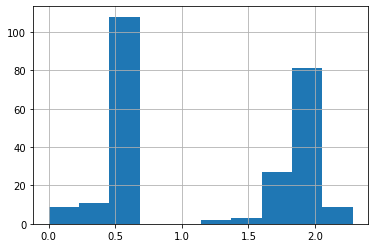

In [6]:
results.value.replace(0, 1).apply(lambda row: np.log10(row )).hist()

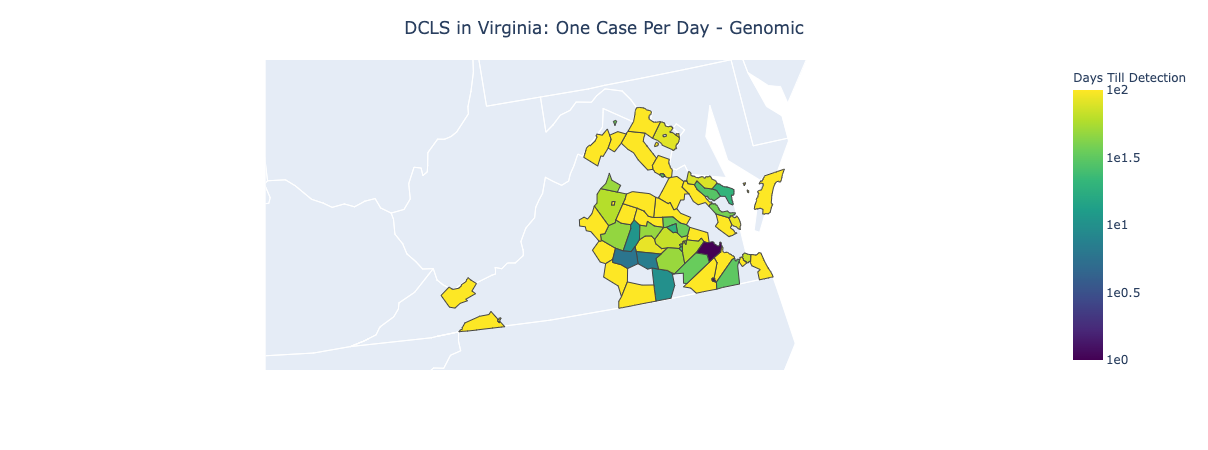

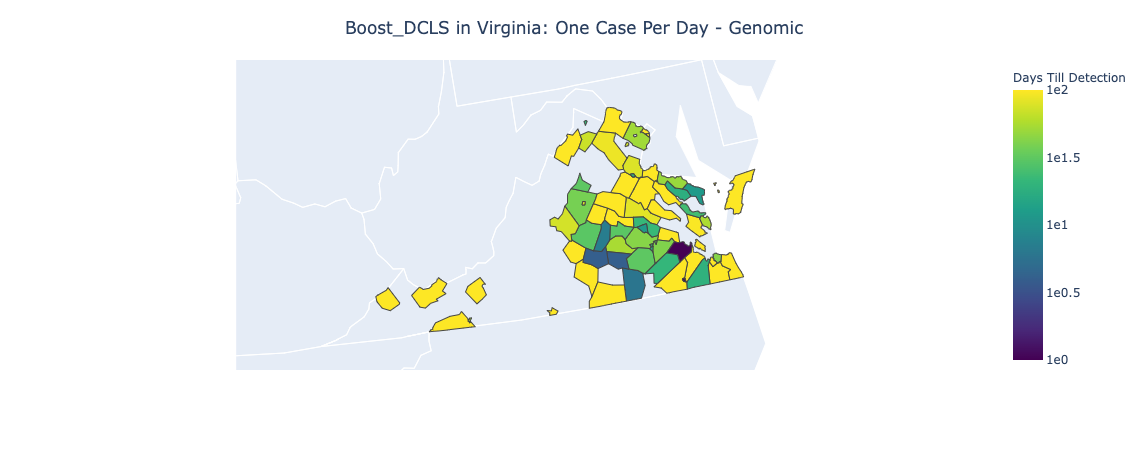

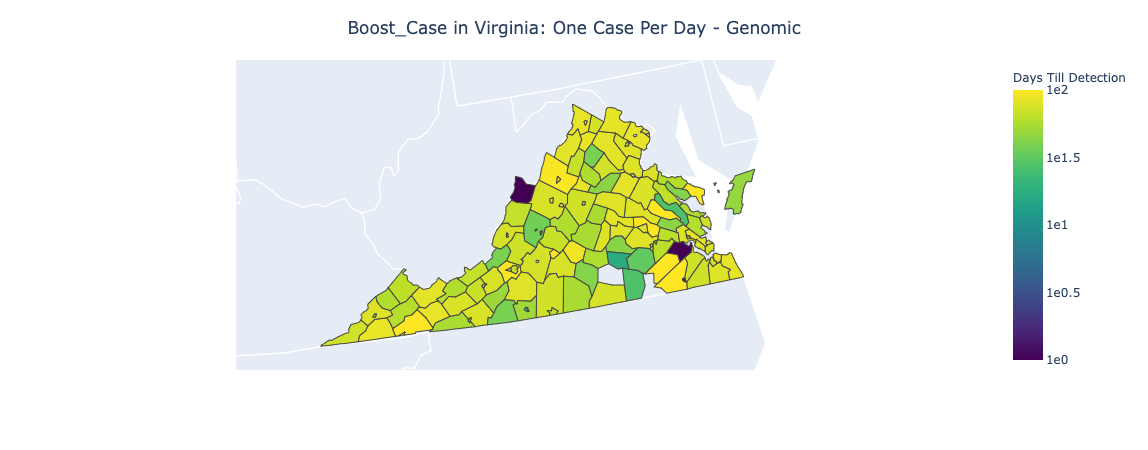

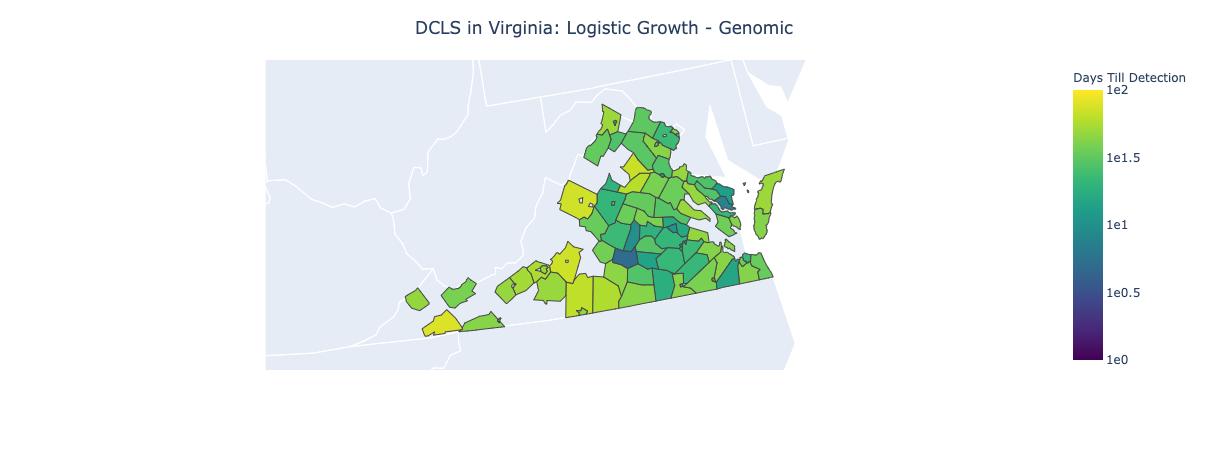

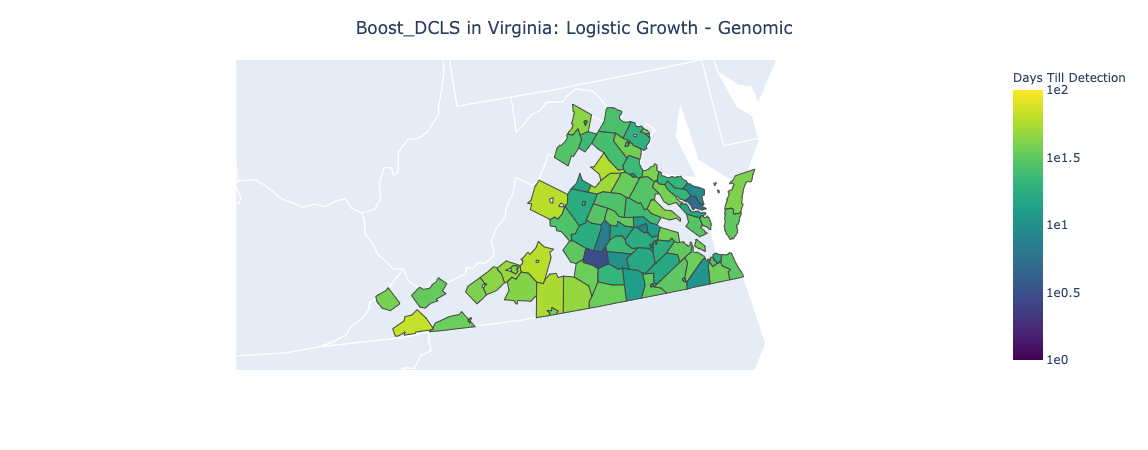

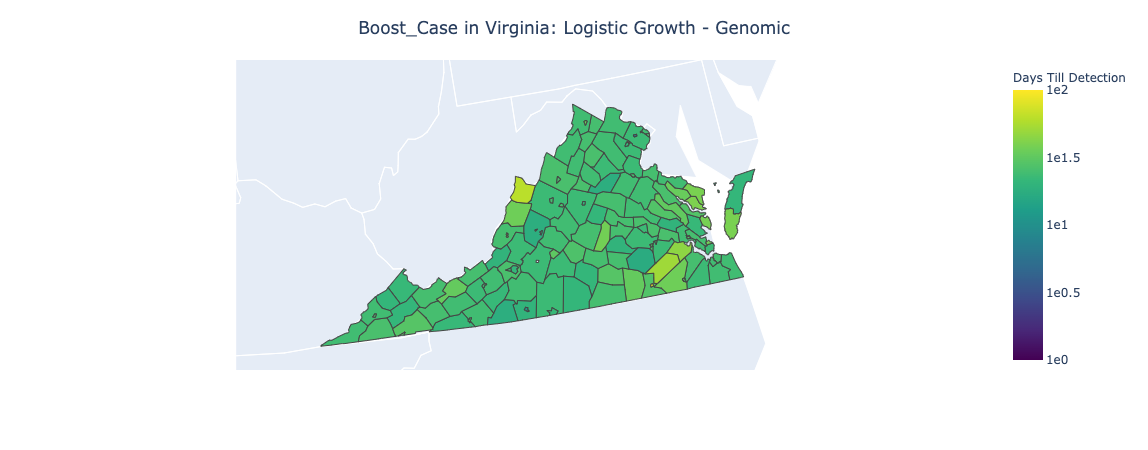

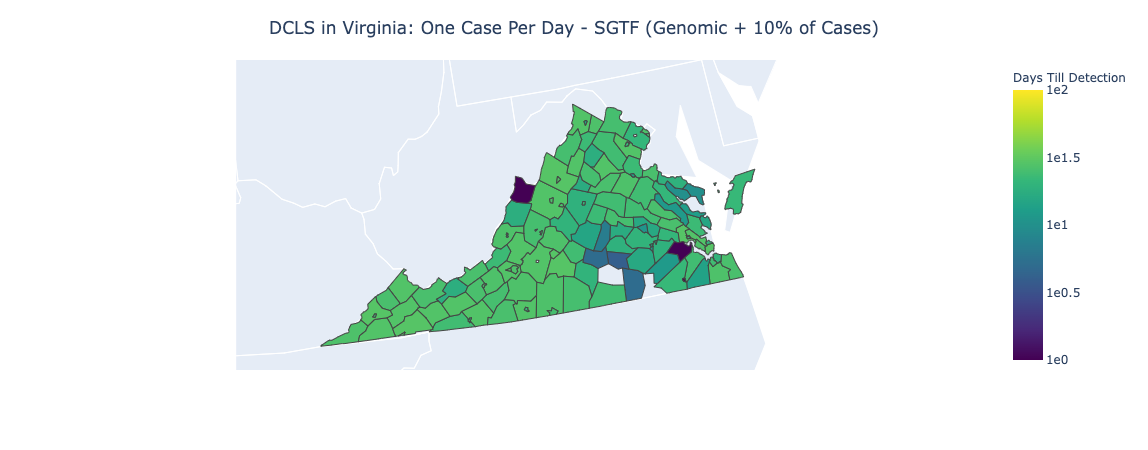

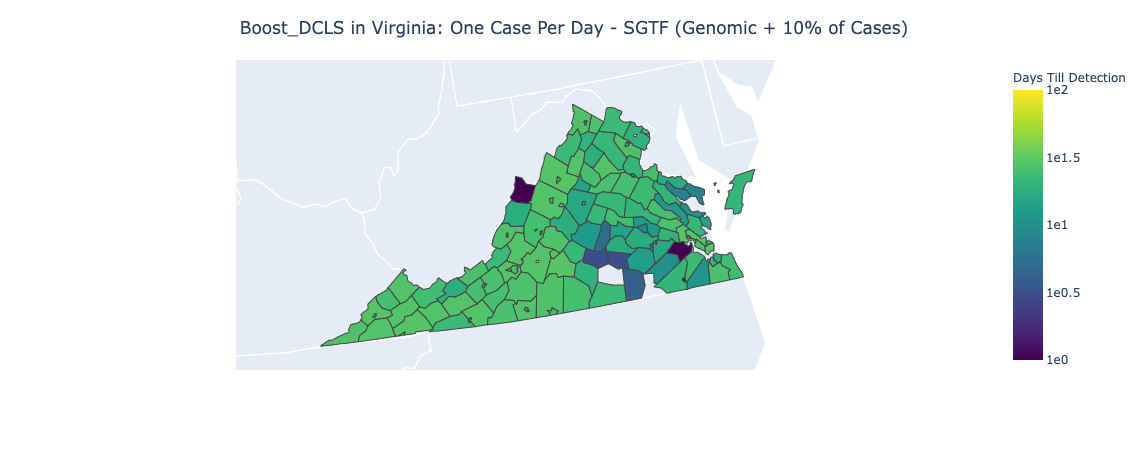

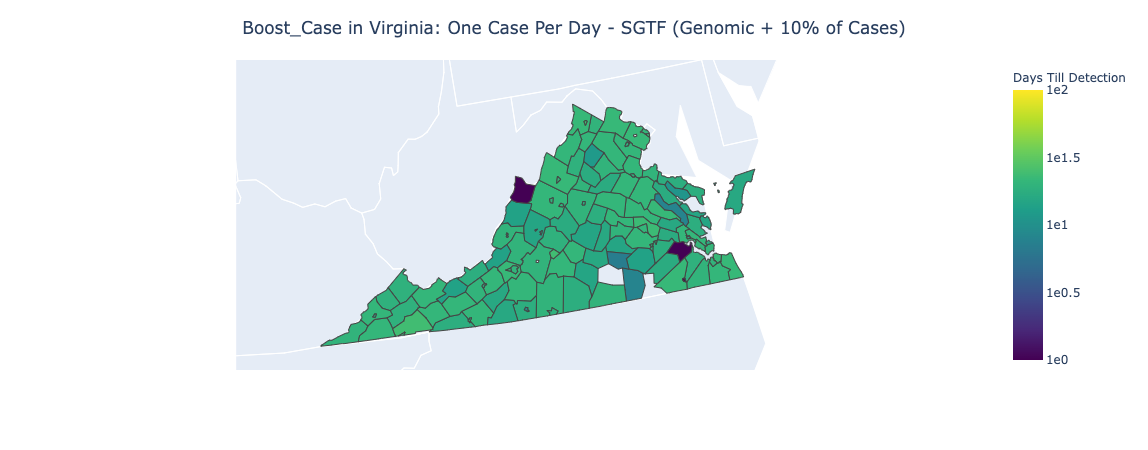

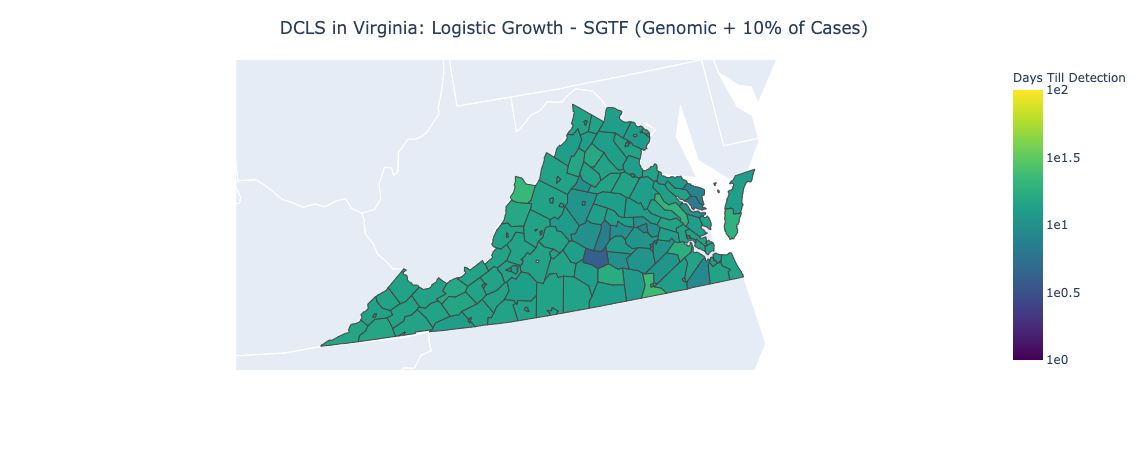

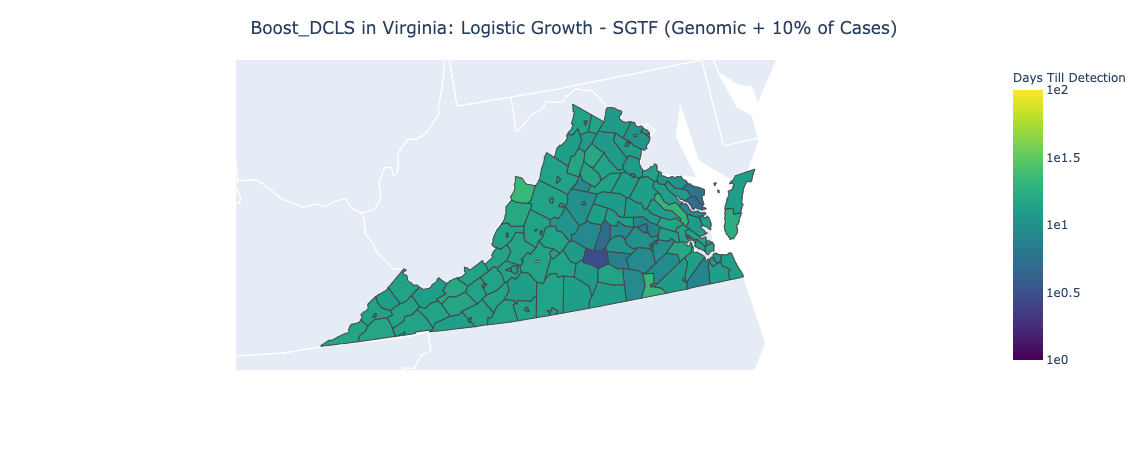

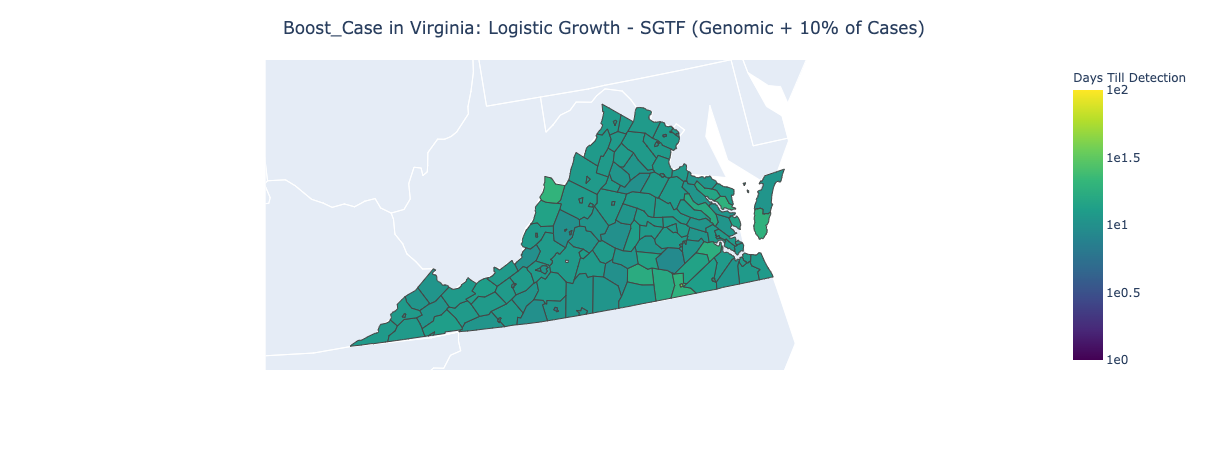

In [63]:
# fig = px.choropleth(results, geojson=counties, locations='fips', color=np.log10(results['value'].replace(0, 1)), facet_col="Test Type",
for ttype in ["Genomic", "SGTF"]:
    test_name = "Genomic" if ttype == "Genomic" else "SGTF (Genomic + 10% of Cases)"
    
    for omicron_scenario in all_options["omicron_scenario"].unique():
        omicron_scenario_name = ": One Case Per Day" if omicron_scenario == "single_case" else ": Logistic Growth"
        for sample_type in all_options.distribution.unique():

            to_plot = all_options[(all_options["Test Type"] == ttype) & (all_options["distribution"] == sample_type) & (all_options["omicron_scenario"] == omicron_scenario)]
        #     fig = px.choropleth(to_plot, geojson=counties, locations='fips', color=np.log10(to_plot['value'].replace(0, 1)), facet_col="distribution",
            fig = px.choropleth(to_plot, geojson=counties, locations='fips', color=np.log10(to_plot['value'].replace(0, 1)),
            #                             endpoints=endpts, colorscale=colorscale,
                                       color_continuous_scale="Viridis",
                                       range_color=(0, 2), #variant_datas.value.max()
                                       scope="usa",
                                       labels={'unemp':'unemployment rate'}
                                      )

            fig.update_geos(fitbounds="geojson", visible=True)
            fig.update_layout(title={
                                'text': f"{sample_type} in Virginia{omicron_scenario_name} - {test_name}",
                                'y':0.95,
                                'x':0.5,
                                'xanchor': 'center',
                                'yanchor': 'top'})
            # fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}) #, 
            #                   title={
            #                     'text': f"{variant_name} in Virginia",
            #                     'y':0.95,
            #                     'x':0.5,
            #                     'xanchor': 'center',
            #                     'yanchor': 'top'})
            # fig.update_layout(transition = {'duration': 1000})
            # fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 400
            fig.update_layout(coloraxis_colorbar=dict(title='Days Till Detection', tickprefix='1e'))
            fig.show()
            fig.write_html(f"virginia_detection_days_by_county_{sample_type.lower().replace(' ', '_')}_{omicron_scenario}_{ttype.lower()}.html")

### USA Analysis

In [27]:
state_to_stfips_path ="/project/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/misc_data/stfips_to_state.csv"
state_to_stfips_df = pd.read_csv(state_to_stfips_path, header=None, dtype={"2":str})
state_to_stfips_df[2] = state_to_stfips_df[2].astype(str).str.zfill(2)
state_to_stfips = state_to_stfips_df.set_index(0)[2].to_dict()
state_to_stfips = state_to_stfips_df.set_index(0)[2].to_dict()
state_to_state_abbr = state_to_stfips_df.set_index(0)[1].to_dict()
stfips_to_state_abbr = state_to_stfips_df.set_index(2)[1].to_dict()
abbr_to_stfips = state_to_stfips_df.set_index(1)[2].to_dict()

fips_to_pop = pd.read_csv("/project/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/misc_data/co-est2019-alldata.csv", encoding="latin-1")
fips_to_pop["fips"] = fips_to_pop.STATE.astype(str).str.zfill(2) + fips_to_pop.COUNTY.astype(str).str.zfill(3).replace("000", "")
fips_to_pop = fips_to_pop.set_index("fips")["CENSUS2010POP"].to_dict()

gisaid = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/variants/variant_samples_by_state.csv", parse_dates=["date"], dtype={"state":str})

rel_countries = ['Australia',
 'Austria',
 'Belgium',
 'Botswana',
 'Canada',
#  'Czech Republic',
 'Denmark',
 'Germany',
 'France',
#  'Hong Kong',
 'Israel',
 'Italy',
 'Japan',
 'Netherlands',
 'Portugal',
 'South Africa',
 'Spain',
 'Sweden',
 'United Kingdom']

jhu_cases = pd.read_csv("/sfs/qumulo/qproject/biocomplexity/COVID-19_commons/products/external_data_collection/JHU/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv").rename(columns={"Country/Region":"country"})
# jhu_cases.FIPS = jhu_cases.FIPS.dropna().astype(int).astype(str).str.zfill(5)
# # jhu_cases.FIPS.dropna().astype(int).astype(str).str.zfill(5)
# jhu_cases = jhu_cases[jhu_cases.FIPS.apply(lambda item: True if item[:2] in stfips_to_state.keys() else False)]
jhu_cases = jhu_cases.set_index("country")[[c for c in jhu_cases.columns if "/" in c and "P" not in c]]
jhu_cases.columns = pd.to_datetime(jhu_cases.columns)
jhu_cases = jhu_cases.T
jhu_cases = jhu_cases.groupby(jhu_cases.columns, axis=1).sum()
jhu_cases = jhu_cases.cummax().diff()
# jhu_cases_state = jhu_cases.copy()
# jhu_cases_state.columns = [c[:2] for c in jhu_cases_state.columns]
# jhu_cases_state = jhu_cases_state.groupby(jhu_cases_state.columns, axis=1).sum()
# cases = jhu_cases_state

jhu_cases = jhu_cases[rel_countries] #.info()

cases = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/NyTimes/us-states.csv", parse_dates=["date"], dtype={"fips":str}).dropna(subset=["fips"])
cases = cases.pivot(index="date", columns="fips", values="cases").fillna(0).diff().rolling(7).mean()
# ratios = (cases.T / cases.sum(axis=1)).T.iloc[-28:].median().to_dict()

cases = pd.concat([cases, jhu_cases], axis=1)

In [33]:
country_samples = pd.read_csv("../../covid/notebooks/country_gisaid_sampling.csv", parse_dates=["Collection date"]).set_index("Collection date")

In [35]:
state_samples = gisaid.groupby(["date", "state"]).count().rename(columns={"variant":"samples"}).reset_index().pivot(index="date", columns="state", values="samples").fillna(0)
genomic_samples_per_day = state_samples.loc["2021-10-09":"2021-11-09"].median().to_dict()
genomic_samples_per_day.update(country_samples.loc["2021-10-09":"2021-11-09"].median().to_dict())

In [36]:
genomic_detection_days = {fips:np.nan for fips in cases}
sgtf_detection_days = {fips:np.nan for fips in cases}

for fips in cases:
    cases_per_day = cases[fips].iloc[-7:].median()
#     print(fips, cases_per_day)
    if cases_per_day == 0:
        continue
    prevalence = 1 / cases_per_day
    sgtf_samples = cases_per_day * 0.7
    
#     print(fips, sgtf_samples)
    
    detection_df = pd.DataFrame([cases_per_day for i in range(300)], index=range(300), columns=["cases"])
    detection_df["prop"] = prevalence
    complement_sgtf = (1 - detection_df["prop"]) ** sgtf_samples
    detection_df["cum_prob_sgtf"] = 1 - complement_sgtf.cumprod()
#     print(detection_df.iloc[:10])
    sgtf_days = detection_df[detection_df.cum_prob_sgtf >= 0.95].index.min()
    
    if fips in genomic_samples_per_day:
        complement_genomic = (1 - detection_df["prop"]) ** genomic_samples_per_day[fips]
        detection_df["cum_prob_genomic"] = 1 - complement_genomic.cumprod()
        genomic_days = detection_df[detection_df.cum_prob_genomic >= 0.95].index.min()
    else:
        genomic_days = np.nan
        
    genomic_detection_days[fips] = genomic_days
    sgtf_detection_days[fips] = sgtf_days
    
genomic_detection_days = pd.Series(genomic_detection_days).rename("Genomic")
sgtf_detection_days = pd.Series(sgtf_detection_days).rename("SGTF")

results = pd.concat([genomic_detection_days, sgtf_detection_days], axis=1)
results = results.melt(ignore_index=False).reset_index().rename(columns={"index":"fips", "variable":"Test Type"})
# results.fips = results.fips.apply(lambda row: stfips_to_state_abbr[row])

In [38]:
results.to_csv("USA_states_and_Euro_days_till_detection.csv", index=False)

In [69]:
results.rename(columns={"value":"days till detection"}).to_csv("USA_states_days_till_detection.csv", index=False)

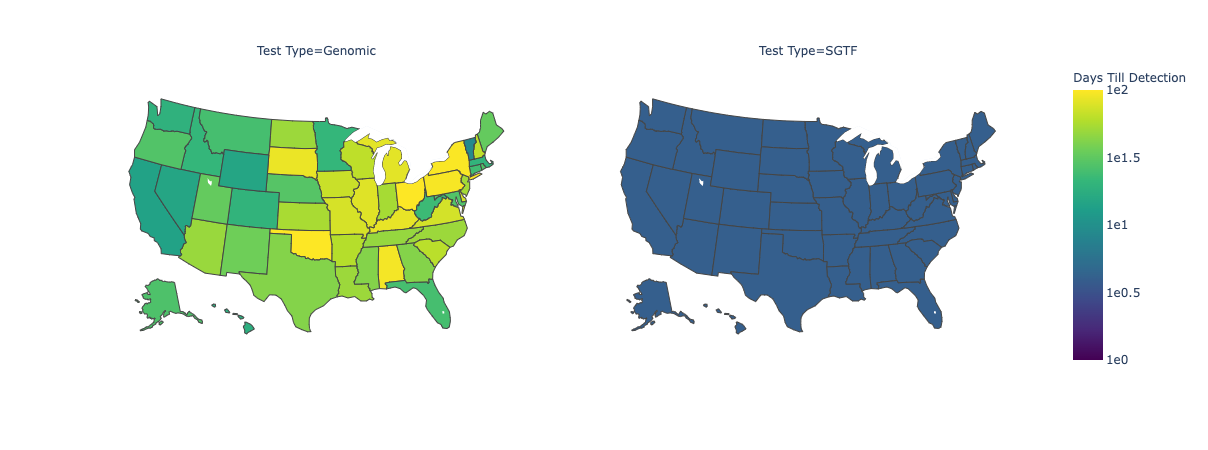

In [270]:
fig = px.choropleth(results, locations='fips', color=np.log10(results['value'].replace(0, 1)), facet_col="Test Type",
#                             endpoints=endpts, colorscale=colorscale,
                           color_continuous_scale="Viridis",
                           range_color=(0, 2), #variant_datas.value.max()
                           scope="usa",
                           locationmode = "USA-states",
                           labels={'unemp':'unemployment rate'}
                          )

# fig.update_geos(fitbounds="geojson", visible=True)
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}) #, 
#                   title={
#                     'text': f"{variant_name} in Virginia",
#                     'y':0.95,
#                     'x':0.5,
#                     'xanchor': 'center',
#                     'yanchor': 'top'})
# fig.update_layout(transition = {'duration': 1000})
# fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 400
fig.update_layout(coloraxis_colorbar=dict(title='Days Till Detection', tickprefix='1e'))
fig.show()
fig.write_html(f"usa_detection_days_by_state.html")

In [103]:
import requests
import json
import pandas as pd
from datetime import datetime
from pathlib import Path
import os, stat, sys

states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

headers = {"accept": "*/*", \
"user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36"}

# data = {"id": "integrated_county_timeseries_state_TX_external"}

dfs = []

for state in states:
    resp = requests.get(f"https://covid.cdc.gov/covid-data-tracker/COVIDData/getAjaxData?id=integrated_county_timeseries_state_{state}_external", headers=headers)
    if resp.status_code != 200:
        print(f"State {state} not found, status code: {resp.status_code}")
        break
        continue
    data = json.loads(resp.text)
    t = pd.DataFrame(data["integrated_county_timeseries_external_data"])
    for c in "date report_date_window_start report_date_window_end".split():
        t[c] = pd.to_datetime(t[c])
    t = t.rename(columns={"fips_code":"fips"})
    t.fips = t.fips.astype(str).str.zfill(5)
    t = t.sort_values("date")
    ordered_cs = ["date", "state", "state_name", "fips", "county"] 
    ordered_cs += list(set(t.columns) - set(ordered_cs))
    t = t[ordered_cs]
    dfs.append(t)
    break

State AL not found, status code: 500
